# Path Tracing Notebook
The first 5 code cells are required only on Google Colab. Ignore them if you are running the notebook from your local machine.

In [1]:
# 1. Run only if you need to delete cached folder from Google Colab
# !rm -rf /content/light-transport

In [2]:
# 2. Download the project files from Github
# !git clone https://github.com/dipanjan92/light-transport.git

In [3]:
# 3. Add the project directory to the system PATH
# import sys
# sys.path.insert(0,'/content/light-transport/LightTransportSimulator')

In [4]:
# 4. PyVista is used to generate 3D objects
# !pip install pyvista

In [5]:
# 5. Switch to project directory
# import os
# os.chdir('/content/light-transport/')
# os.getcwd()

********************************************************************************************

In [6]:
import math
import shutil
import time
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
import numba
import pyvista as pv
import seaborn as sns
import pandas as pd

In [7]:
import os
os.chdir('G:/My Drive/Projects/light-transport/')
# os.chdir('/Users/yifan/Google Drive/My Drive/Projects/light-transport/')
os.getcwd()

'G:\\My Drive\\Projects\\light-transport'

In [8]:
from LightTransportSimulator.light_transport.src.scene import Scene, Light
from LightTransportSimulator.light_transport.src.primitives import Triangle, PreComputedTriangle
from LightTransportSimulator.light_transport.src.cornell_box import get_cornell_box, get_floor
from LightTransportSimulator.light_transport.src.constants import *

In [9]:
# load a 3D object using PyVista
mesh = pv.Cone(radius=2, center=[0,0,0], height=5)
tri = mesh.triangulate()
points = np.ascontiguousarray(tri.points)
faces = tri.faces.reshape((-1,4))[:, 1:4]
vertices = np.ascontiguousarray(points[faces], dtype=np.float64)
len(vertices)

10

In [10]:
#set scene depths

xmax, ymax, zmax = points.max(axis=0)
xmin, ymin, zmin = points.min(axis=0)

# set padding to be added around the object
padding = 5
depth = abs(max(xmax, ymax, zmax)) + padding
x_depth = abs(xmax) + 10
y_depth = abs(ymax) + 1
z_depth = abs(zmax) + 10
xmax, ymax, zmax, depth

(2.5, 2.0, 1.7320508, 7.5)

In [11]:
# Initialise an empty list for primitives
objects = numba.typed.List()

In [12]:
from LightTransportSimulator.light_transport.src.cornell_box import get_floor

# Set wall colors and materials for the Cornell box

surface_color = WHITE_2
left_wall_color = RED
right_wall_color = GREEN
surface_mat = Material(color=surface_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1) # calcium sulphate
left_wall_mat = Material(color=left_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)
right_wall_mat = Material(color=right_wall_color, shininess=30, reflection=0.1, ior=1.5210, transmission=1)

# Get the triangles required to render the Cornell box
objects = get_cornell_box(depth, surface_mat, left_wall_mat, right_wall_mat)
# objects = get_floor(x_depth, y_depth, z_depth, surface_mat)

In [13]:
# Add the triangles in the list of objects
for v in vertices:
    a,b,c = np.append(v[0], 1),np.append(v[1], 1),np.append(v[2], 1)

    triangle = PreComputedTriangle(vertex_1=np.ascontiguousarray(a, dtype=np.float64),
                                   vertex_2=np.ascontiguousarray(b, dtype=np.float64),
                                   vertex_3=np.ascontiguousarray(c, dtype=np.float64),
                                   material=GLASS_MAT)
    objects.append(triangle)

objects

ListType[instance.jitclass.PreComputedTriangle#1df17238280<type:int64,vertex_1:array(float64, 1d, C),vertex_2:array(float64, 1d, C),vertex_3:array(float64, 1d, C),centroid:array(float64, 1d, C),material:instance.jitclass.Material#1df7f62b6d0<color:instance.jitclass.Color#1df7f569d50<ambient:array(float64, 1d, A),diffuse:array(float64, 1d, A),specular:array(float64, 1d, A)>,shininess:float64,reflection:float64,ior:float64,is_diffuse:bool,is_mirror:bool,emission:float64,transmission:float64>,is_light:bool,edge_1:array(float64, 1d, C),edge_2:array(float64, 1d, C),normal:array(float64, 1d, C),num:float64,transformation:array(float64, 2d, A)>]([<numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001DF172B1750>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001DF172B0280>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001DF172B1750>, <numba.experimental.jitclass.boxing.PreComputedTriangle object at 0x000001DF172B0280>, <num

In [14]:
from LightTransportSimulator.light_transport.src.light_samples import generate_area_light_samples

# # Create a global light source

source_mat = Material(color=WHITE, shininess=1, reflection=0.9, ior=1.5, emission=200)

# As conventional Cornell box has square light source (Area light),
# we will use two triangles to render the light source
light_1 = PreComputedTriangle(vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, 1, 1], dtype=np.float64),
                              vertex_3=np.array([-1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

light_2 = PreComputedTriangle(vertex_1=np.array([-1, depth, -1, 1], dtype=np.float64),
                              vertex_2=np.array([1, depth, -1, 1], dtype=np.float64),
                              vertex_3=np.array([1, depth, 1, 1], dtype=np.float64),
                              material=source_mat,
                              is_light=True)

# generate random samples on the light emitting surfaces
light_sources = generate_area_light_samples(tri_1=light_1,
                                          tri_2=light_2,
                                          source_mat=source_mat,
                                          number_of_samples=1000,
                                          total_area=4)

G:\My Drive\Projects\light-transport\LightTransportSimulator\light_transport\src\intersects.py:26: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  b = 2 * np.dot(ray_direction, ray_origin - center)
G:\My Drive\Projects\light-transport\LightTransportSimulator\light_transport\src\intersects.py:26: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (array(float64, 1d, A), array(float64, 1d, C))
  b = 2 * np.dot(ray_direction, ray_origin - center)


In [15]:
objects.append(light_1)
objects.append(light_2)

In [25]:
# Setup scene

# point camera
camera = np.array([0, 0, depth+0.5, 1], dtype=np.float64)

# screen
width=150
height=150

# max_depth is the conventional term used in rendering to denote
# the maximum number of times a ray can bounce within the scene
max_depth=4
# number of samples per pixel
n_samples = 50

# Initialise the scene with lights and camera
# scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, f_distance=depth, number_of_samples=n_samples)

In [26]:
from LightTransportSimulator.light_transport.src.bvh_new import BoundedBox, BVHNode, build_bvh, LinearBVHNode, flatten_bvh, intersect_bvh

# Enclose all the primitives in their individual axis-aligned bounding boxes (AABB)
bounded_boxes = []
for i in range(len(objects)):
    bounded_boxes.append(BoundedBox(objects[i], i))

len(objects), len(bounded_boxes)

(28, 28)

In [27]:
# Initialise a bounding volume hierarchy tree
start = 0
end = len(bounded_boxes)
ordered_prims = []
total_nodes = 0
root, bounded_boxes, ordered_prims, total_nodes = build_bvh(objects, bounded_boxes, start, end, ordered_prims, total_nodes)
# swap the primitives array with the ordered list
primitives = ordered_prims
# root node of the bvh tree
root

In [28]:
# create a linear representation of the bvh tree
linear_nodes = numba.typed.List()
for _ in range(total_nodes):
    linear_nodes.append(LinearBVHNode())
# linear_nodes = [LinearBVHNode() for _ in range(total_nodes)]
len(linear_nodes) # equals to the number of nodes in the original tree

43

In [29]:
# linear bvh
linear_bvh, off_set = flatten_bvh(linear_nodes, root, 0)
len(linear_bvh)

43

In [30]:
# check if indexes of all primitives present in the linear bvh tree
total = 0
for _bvh in linear_bvh:
    total+= _bvh.n_primitives
total # should be equal to the number of primitives

28

In [31]:
# from LightTransportSimulator.light_transport.src.primitives import AABB
#
# # Enclose all the primitives in a single axis-aligned bounding boxes (AABB)
#
# min_point=np.array([-depth, -depth, depth], dtype=np.float64)
# max_point=np.array([depth, depth, -depth], dtype=np.float64)
# box = AABB(min_point=min_point, max_point=max_point)
# # box

In [32]:
# from LightTransportSimulator.light_transport.src.bvh import BVH
# # Initialise a bounding volume hierarchy tree
# bvh = BVH()
# # Add the primitives into the tree
# bvh.insert(objects, box)

0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
0.6666666666666667
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
1.3333333333333335
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.0
2.666666666666667
2.666666666666667
2.0
2.666666666666667
2.666666666666667
2.666666666666667
2.0
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
2.666666666666667
3.3333333333333335
3.3333333333333335
3.3333333333333335
3.3333333333333335


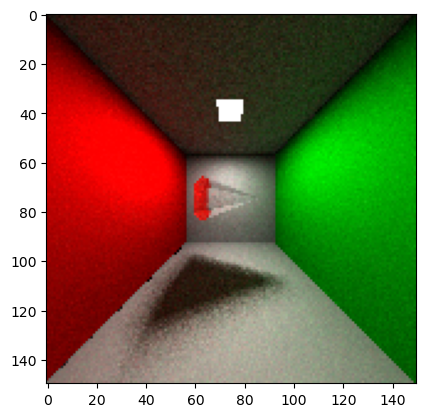

In [34]:
from LightTransportSimulator.light_transport.src.path_tracing_fix1 import render_scene

# Initialise the scene with lights and camera
start = time.time()
np.random.seed(0)
scene = Scene(camera=camera, lights=light_sources, width=width, height=height, max_depth=max_depth, f_distance=depth, number_of_samples=n_samples)
image = render_scene(scene, objects, linear_bvh)

end = time.time()
print("Elapsed (with compilation) = %s" % (end - start))

plt.imshow(image)
